In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt
from datetime import datetime

In [3]:
inicio = datetime.now()

# Importação da base de dados

In [4]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/porto_ts.csv')

In [5]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [6]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [7]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [8]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)

print(original)

      ano  mes     porto        data
0    2005    1   5027941  2005-01-01
1    2005    2   5316605  2005-02-01
2    2005    3   5899912  2005-03-01
3    2005    4   5850639  2005-04-01
4    2005    5   6826372  2005-05-01
..    ...  ...       ...         ...
211  2022    8  14626790  2022-08-01
212  2022    9  13628567  2022-09-01
213  2022   10  14435751  2022-10-01
214  2022   11  12194409  2022-11-01
215  2022   12  12096270  2022-12-01

[216 rows x 4 columns]


In [9]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0      2005-01-01
1      2005-02-01
2      2005-03-01
3      2005-04-01
4      2005-05-01
          ...    
211    2022-08-01
212    2022-09-01
213    2022-10-01
214    2022-11-01
215    2022-12-01
Name: data, Length: 216, dtype: object

## Normalização da data


In [10]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [11]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [12]:
original_std = original[['data_std', 'porto_std']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-12-66111c678ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std
data_std,
0.000000,0.041554
0.004651,0.068844
0.009302,0.123990
0.013953,0.119332
0.018605,0.211578
...,...
0.981395,0.949035
0.986047,0.854662
0.990698,0.930974


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [32]:
# Definindo os dados para treinamento
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.95                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total

# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')

204 meses
17.0 anos
93.98 %


In [33]:
# Final do período de treino
original.iloc[treino_split]

ano                2021
mes                  12
porto          12122719
data         2021-12-01
data_std       0.944186
porto_std      0.712299
Name: 203, dtype: object

In [34]:
# separação treino/teste
x_treino = x[ :treino_split+1]
x_teste  = x[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]


In [35]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

204 204 12 12


In [36]:
#x_treino
#x_teste
#y_treino
y_teste

array([0.57778763, 0.78576679, 0.99933207, 0.87020758, 0.91222703,
       0.90346642, 0.94496306, 0.94903511, 0.85466245, 0.93097416,
       0.7190762 , 0.70979807])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

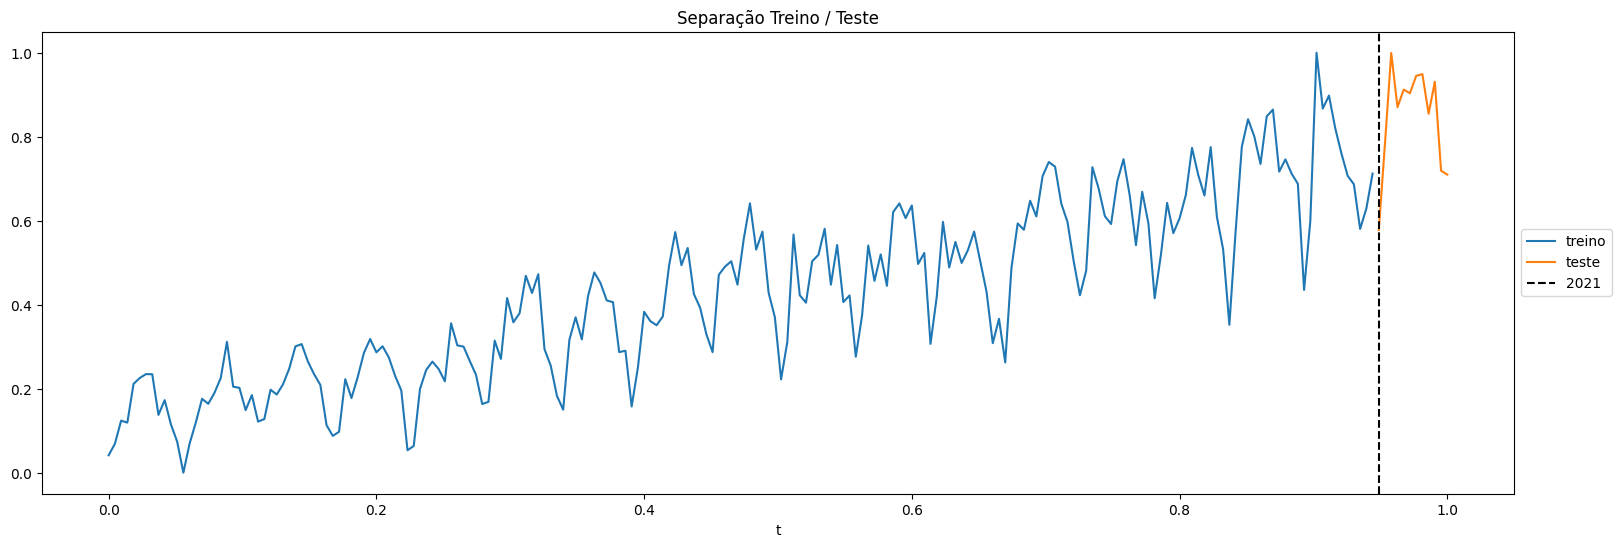

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(19,6))
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), label='treino', ax=ax)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='teste', ax=ax)
ax.axvline(x=x_teste.flatten()[0], linestyle='--', label='2021', color='black')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')

# Modelo Prophet - Matern 32

usando função de covariância de kernel rational quadratic e Matern com nu = 3/2

In [ ]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125)
    trend = pm.Deterministic("trend",a + b*x_treino)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [55]:
with pm.Model() as model:

    # Definindo os hiperparâmetros do kernel RatQuad
    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    # Kernel RatQuad
    #cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)

    # Definindo os hiperparâmetros do kernel Matern 3/2
    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    # Kernel Matern 3/2
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    # Definindo os hiperparâmetros do kernel Gamma (ExpQuad)
    l_gamma = pm.HalfNormal('l_gamma', sigma=0.1)
    sigma_gamma = pm.HalfNormal('sigma_gamma', sigma=0.1)

    # Kernel Gamma (usando um kernel exponencial como aproximação)
    cov_gamma = sigma_gamma * pm.gp.cov.ExpQuad(1, l_gamma)

    # Somando os três kernels
    cov = cov_ratquad + cov_matern32 + cov_gamma

    # Definindo a tendência linear
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.125)
    trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    # Definindo o modelo GP
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)

    # Definindo a variância do ruído
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Definindo a verossimilhança
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1, 1), y=y_treino, noise=sigma)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


## Preditiva a priori

Para ajustar os parâmetros

In [56]:
with model:
  prior = pm.sample_prior_predictive()

In [57]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-58-650b73390703>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-58-650b73390703>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

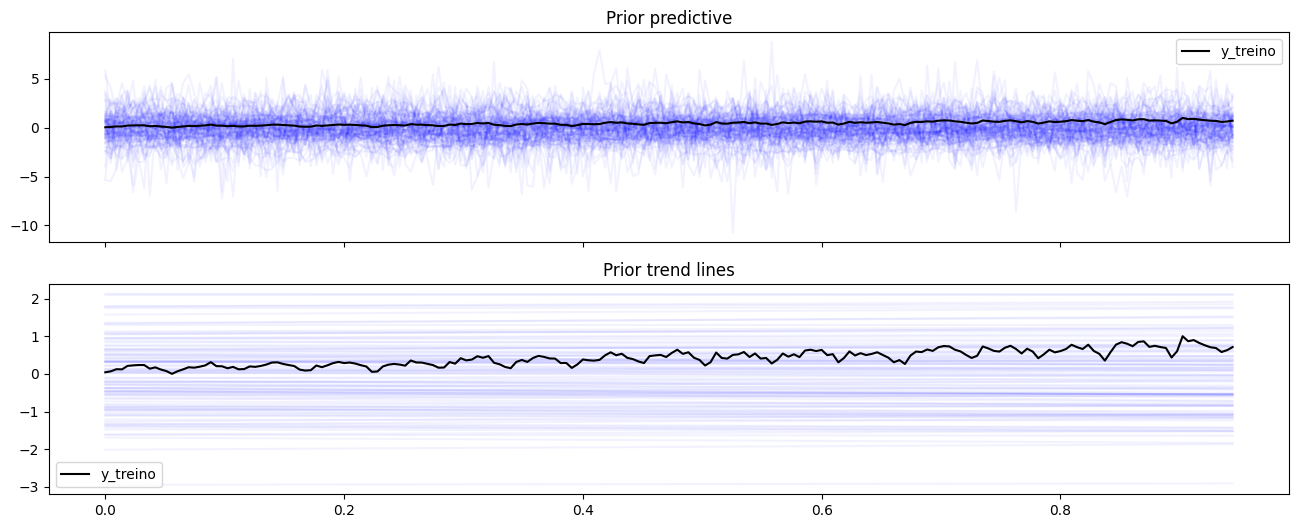

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [59]:
with model:
  trace = pm.sample()

In [61]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.365,0.160,0.090,0.685,0.005,0.004,1171.0,830.0,1.0
b,0.100,0.131,-0.140,0.347,0.003,0.003,1567.0,1312.0,1.0
l_ratquad,3.233,2.398,0.002,7.520,0.060,0.043,1017.0,600.0,1.0
alpha_ratquad,3.236,2.365,0.013,7.384,0.055,0.039,1180.0,740.0,1.0
sigma_ratquad,3.244,2.406,0.001,7.590,0.054,0.038,1187.0,664.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[199],0.457,0.166,0.145,0.761,0.004,0.003,1577.0,1273.0,1.0
trend[200],0.458,0.166,0.146,0.761,0.004,0.003,1580.0,1273.0,1.0
trend[201],0.458,0.166,0.146,0.761,0.004,0.003,1583.0,1282.0,1.0
trend[202],0.459,0.167,0.145,0.761,0.004,0.003,1584.0,1282.0,1.0


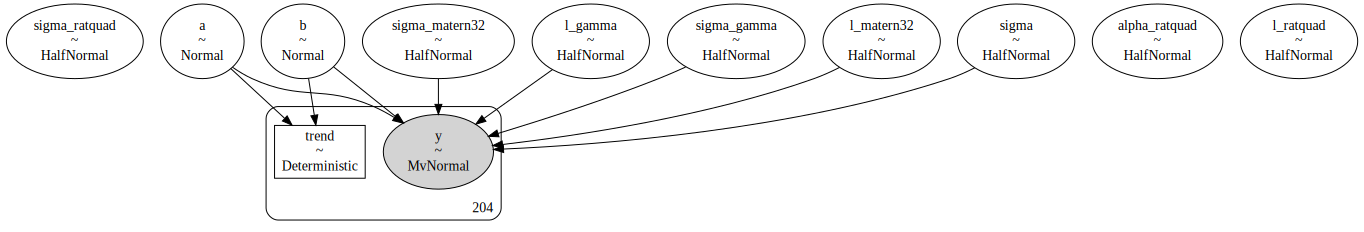

In [62]:
pm.model_to_graphviz(model)

In [63]:
with model:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_teste"])

In [64]:
pred_m

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-65-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

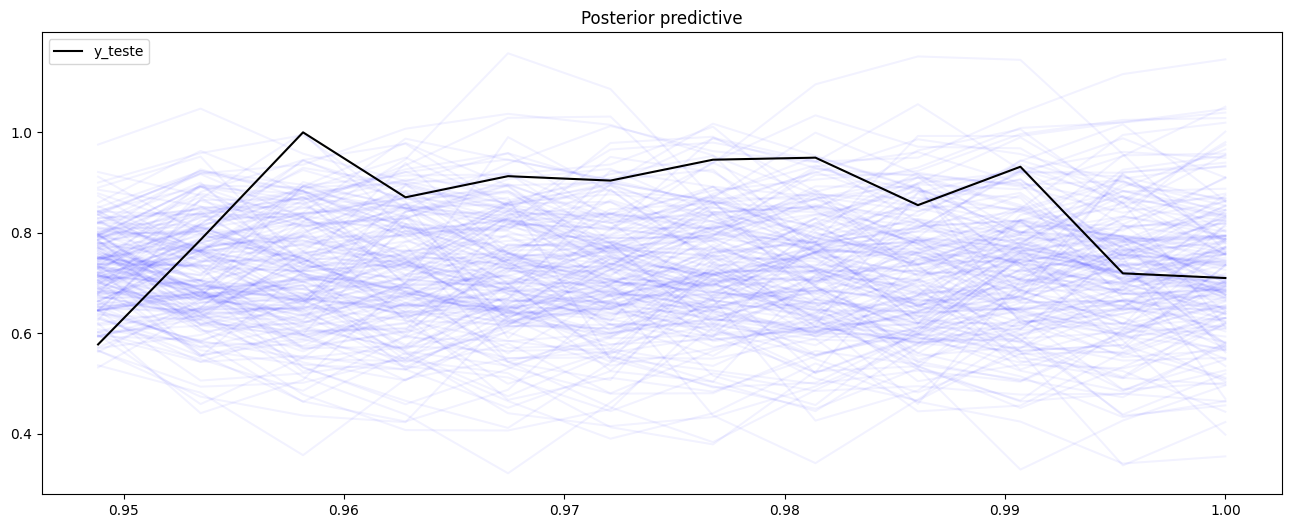

In [65]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [66]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 12, sample: 2000)>
array([[0.86332289, 0.53288907, 0.65862967, ..., 0.7909088 , 0.61112355,
        0.70415956],
       [0.83740029, 0.6032195 , 0.67728388, ..., 0.7237887 , 0.6058915 ,
        0.57664234],
       [0.71118087, 0.65249061, 0.61141903, ..., 0.68041401, 0.64323298,
        0.60251385],
       ...,
       [0.78486456, 0.62965601, 0.68304201, ..., 0.82201831, 0.59448645,
        0.77882244],
       [0.79743509, 0.47316756, 0.75309872, ..., 0.8479914 , 0.6846447 ,
        0.64893229],
       [0.87052256, 0.5022709 , 0.76771638, ..., 0.95806004, 0.73025831,
        0.6922627 ]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

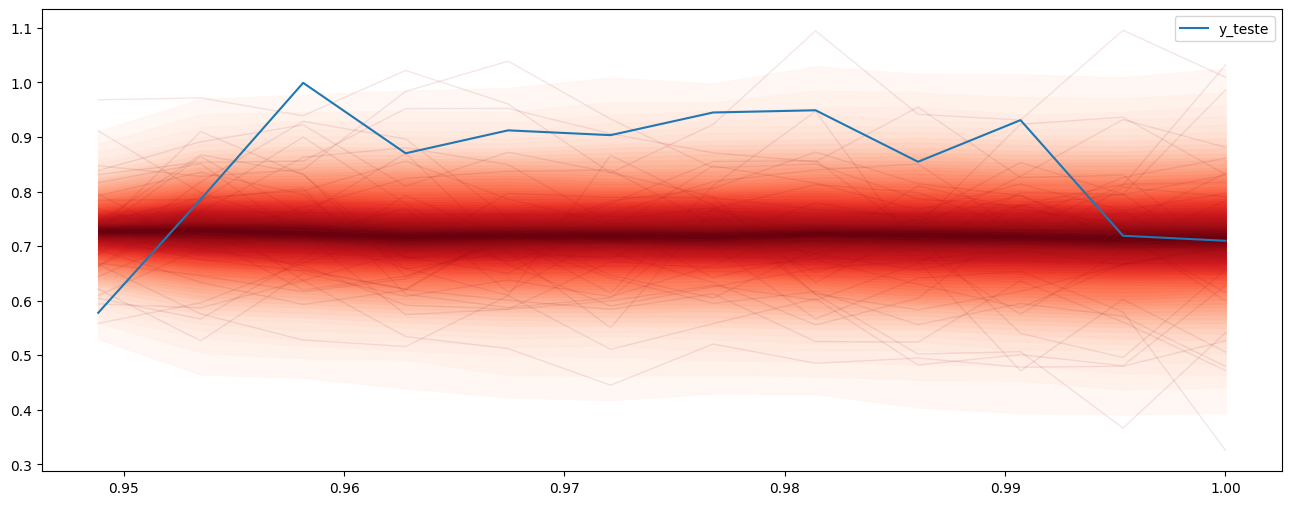

In [67]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [68]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.1495732728303385


###Modelo 2 com Gamma

In [69]:
with pm.Model() as model2:

    # Definindo os hiperparâmetros do kernel RatQuad
    l_ratquad = pm.Gamma('l_ratquad', alpha=2, beta=0.5)
    alpha_ratquad = pm.Gamma('alpha_ratquad', alpha=2, beta=0.5)
    sigma_ratquad = pm.Gamma('sigma_ratquad', alpha=2, beta=0.5)

    # Kernel RatQuad
    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)

    # Definindo os hiperparâmetros do kernel Matern 3/2
    l_matern32 = pm.Gamma('l_matern32', alpha=2, beta=0.5)
    sigma_matern32 = pm.Gamma('sigma_matern32', alpha=2, beta=0.5)

    # Kernel Matern 3/2
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    # Definindo os hiperparâmetros do kernel Gamma (ExpQuad)
    l_gamma = pm.Gamma('l_gamma', alpha=2, beta=0.5)
    sigma_gamma = pm.Gamma('sigma_gamma', alpha=2, beta=0.5)

    # Kernel Gamma (usando um kernel exponencial como aproximação)
    cov_gamma = sigma_gamma * pm.gp.cov.ExpQuad(1, l_gamma)

    # Somando os três kernels
    cov = cov_ratquad + cov_matern32 + cov_gamma

    # Definindo a tendência linear
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.125)
    trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    # Definindo o modelo GP
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)

    # Definindo a variância do ruído
    sigma = pm.Gamma('sigma', alpha=2, beta=0.5)

    # Definindo a verossimilhança
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1, 1), y=y_treino, noise=sigma)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [70]:
with model2:
  prior2 = pm.sample_prior_predictive()

<ipython-input-71-8b8de7241629>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior2, group="prior_predictive", num_samples=100)["y"]
<ipython-input-71-8b8de7241629>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior2, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

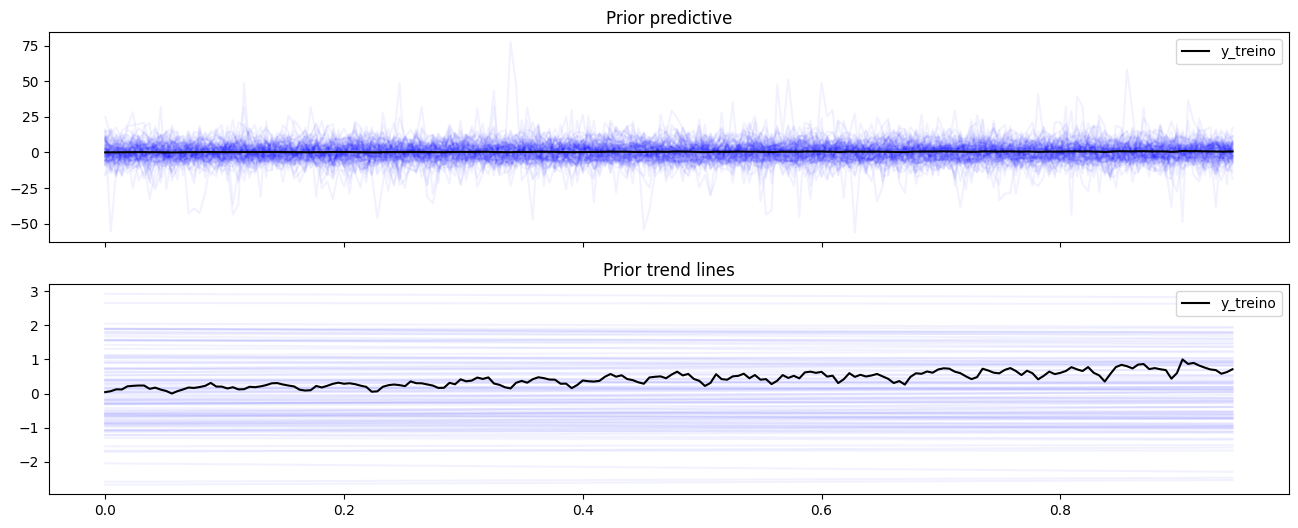

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior2, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior2, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [72]:
with model2:
  trace2 = pm.sample()
pm.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.087,0.886,-1.622,1.672,0.016,0.022,2912.0,1396.0,1.00
b,0.023,0.120,-0.209,0.250,0.003,0.003,2126.0,1374.0,1.00
l_ratquad,4.147,2.829,0.156,9.364,0.052,0.043,2800.0,1079.0,1.01
alpha_ratquad,4.865,2.696,0.925,9.687,0.052,0.041,2965.0,1611.0,1.00
sigma_ratquad,3.355,2.348,0.058,7.287,0.050,0.039,1971.0,1358.0,1.00
...,...,...,...,...,...,...,...,...,...
trend[199],0.108,0.893,-1.605,1.691,0.017,0.022,2873.0,1394.0,1.00
trend[200],0.108,0.893,-1.605,1.691,0.017,0.022,2872.0,1394.0,1.00
trend[201],0.108,0.893,-1.605,1.691,0.017,0.022,2871.0,1394.0,1.00
trend[202],0.108,0.893,-1.605,1.691,0.017,0.022,2871.0,1394.0,1.00


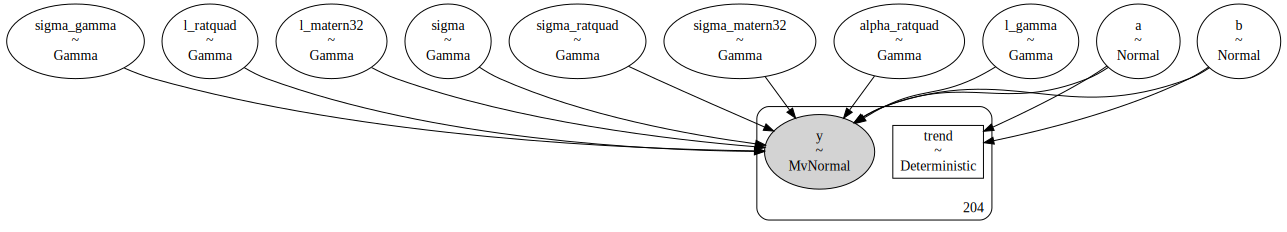

In [73]:
pm.model_to_graphviz(model2)

In [74]:
with model2:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace2, var_names=["x_teste"])

<ipython-input-75-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

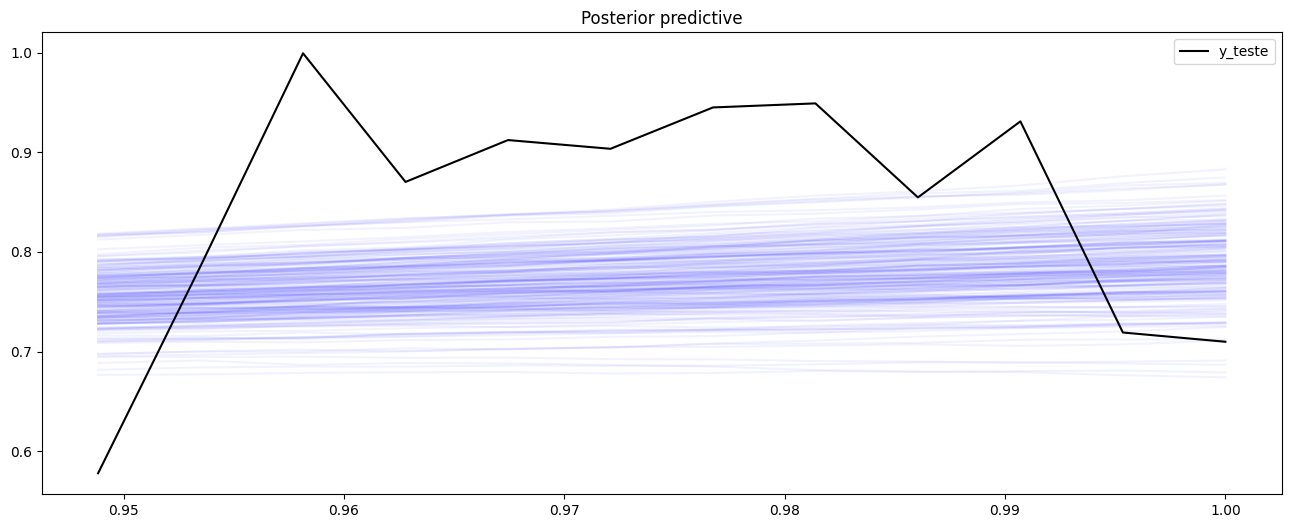

In [75]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [76]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 12, sample: 2000)>
array([[0.75383813, 0.74312537, 0.79024055, ..., 0.73385319, 0.75247567,
        0.76114648],
       [0.75484405, 0.74671445, 0.7933594 , ..., 0.7370605 , 0.75501046,
        0.76477253],
       [0.75974013, 0.74777154, 0.79885468, ..., 0.74116289, 0.75880564,
        0.76853028],
       ...,
       [0.78208748, 0.76214081, 0.8242835 , ..., 0.76719282, 0.77920748,
        0.79403499],
       [0.78485841, 0.76350571, 0.82616853, ..., 0.76993845, 0.78421284,
        0.79988922],
       [0.7869984 , 0.7640223 , 0.828189  , ..., 0.77299874, 0.78696582,
        0.80227273]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

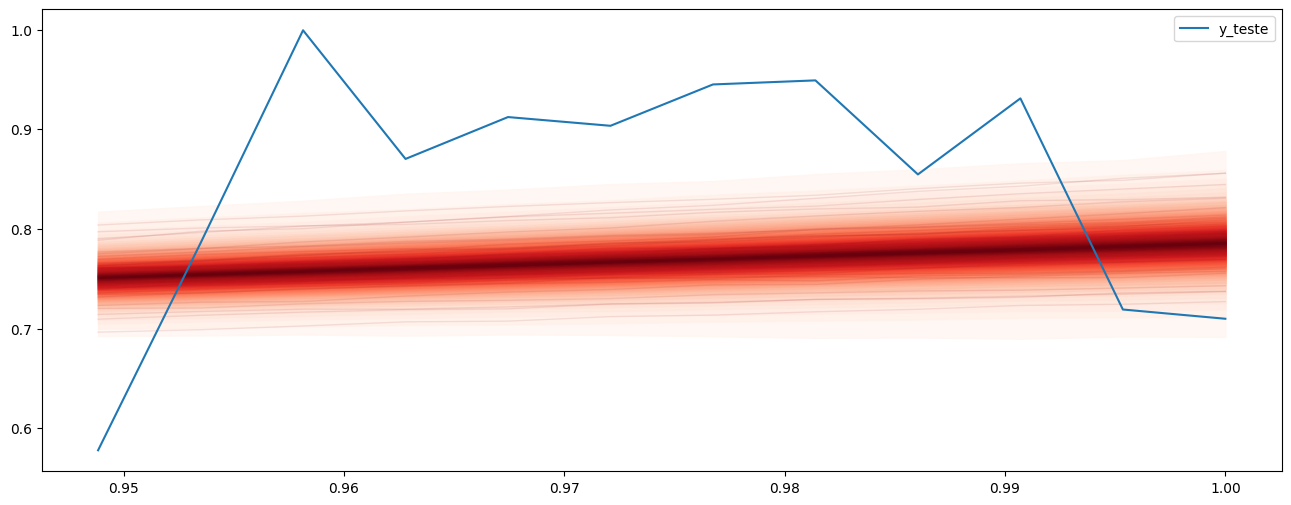

In [77]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [78]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.12951358511308697


###Modelo 3 com Gamma

In [80]:
with pm.Model() as model3:

    # Definindo os hiperparâmetros do kernel RatQuad
    l_ratquad = pm.Gamma('l_ratquad', alpha=9, beta=2)
    alpha_ratquad = pm.Gamma('alpha_ratquad', alpha=9, beta=2)
    sigma_ratquad = pm.Gamma('sigma_ratquad', alpha=9, beta=2)

    # Kernel RatQuad
    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)

    # Definindo os hiperparâmetros do kernel Matern 3/2
    l_matern32 = pm.Gamma('l_matern32', alpha=9, beta=2)
    sigma_matern32 = pm.Gamma('sigma_matern32', alpha=9, beta=2)

    # Kernel Matern 3/2
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    # Definindo os hiperparâmetros do kernel Gamma (ExpQuad)
    l_gamma = pm.Gamma('l_gamma', alpha=9, beta=2)
    sigma_gamma = pm.Gamma('sigma_gamma', alpha=9, beta=2)

    # Kernel Gamma (usando um kernel exponencial como aproximação)
    cov_gamma = sigma_gamma * pm.gp.cov.ExpQuad(1, l_gamma)

    # Somando os três kernels
    cov = cov_ratquad + cov_matern32 + cov_gamma

    # Definindo a tendência linear
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.125)
    trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    # Definindo o modelo GP
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)

    # Definindo a variância do ruído
    sigma = pm.Gamma('sigma', alpha=9, beta=2)

    # Definindo a verossimilhança
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1, 1), y=y_treino, noise=sigma)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [81]:
with model3:
  prior3 = pm.sample_prior_predictive()

<ipython-input-82-32e1cde81e44>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior3, group="prior_predictive", num_samples=100)["y"]
<ipython-input-82-32e1cde81e44>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior3, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

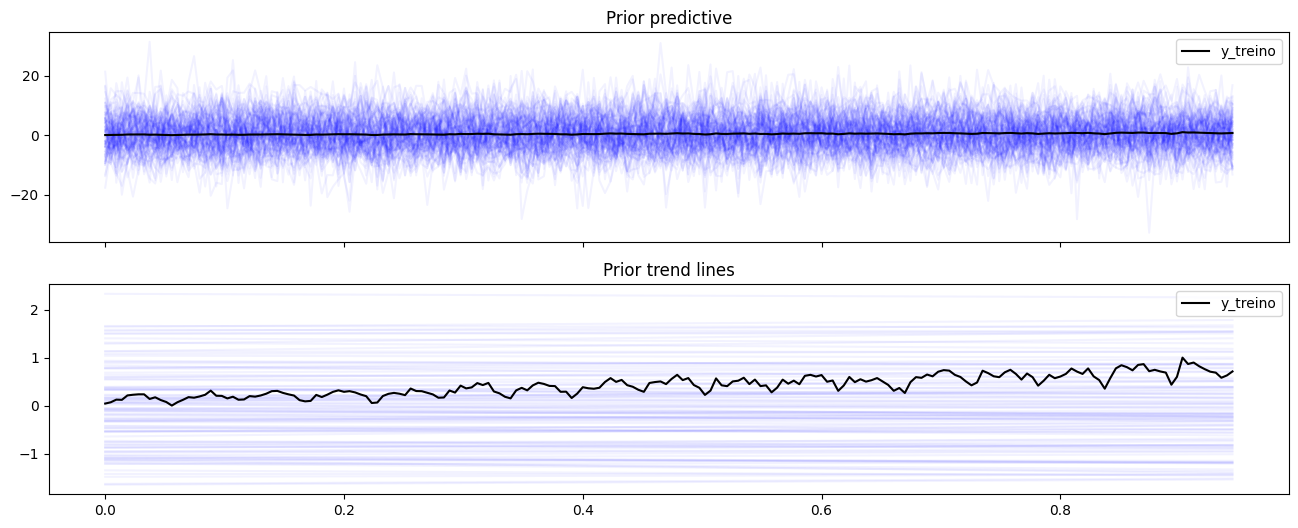

In [82]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior3, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior3, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [83]:
with model3:
  trace3 = pm.sample()
pm.summary(trace3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.057,0.928,-1.622,1.726,0.018,0.022,2764.0,1494.0,1.0
b,0.018,0.124,-0.217,0.247,0.003,0.003,2273.0,1351.0,1.0
l_ratquad,4.502,1.529,1.447,7.147,0.027,0.019,2972.0,1134.0,1.0
alpha_ratquad,4.631,1.436,2.070,7.323,0.029,0.021,2354.0,1361.0,1.0
sigma_ratquad,4.370,1.403,1.863,7.022,0.027,0.020,2661.0,1321.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[199],0.074,0.933,-1.661,1.724,0.018,0.022,2777.0,1349.0,1.0
trend[200],0.074,0.933,-1.661,1.725,0.018,0.022,2776.0,1349.0,1.0
trend[201],0.074,0.933,-1.662,1.726,0.018,0.022,2776.0,1349.0,1.0
trend[202],0.074,0.933,-1.662,1.727,0.018,0.022,2776.0,1349.0,1.0


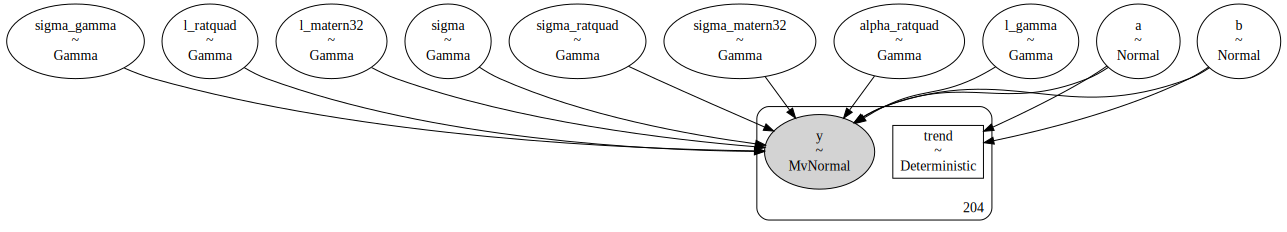

In [84]:
pm.model_to_graphviz(model3)

In [85]:
with model3:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace3, var_names=["x_teste"])

<ipython-input-86-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

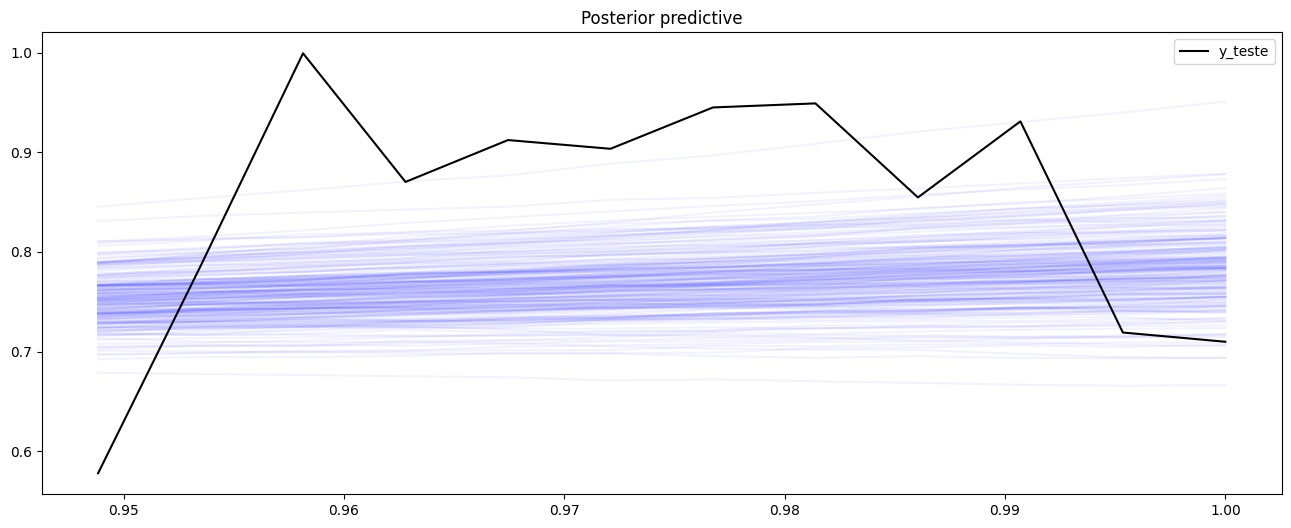

In [86]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [87]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 12, sample: 2000)>
array([[0.75692392, 0.73730219, 0.74137274, ..., 0.78378994, 0.78685352,
        0.75685165],
       [0.75888003, 0.74019191, 0.74334864, ..., 0.78682324, 0.7885999 ,
        0.75885187],
       [0.75719401, 0.74423551, 0.74716548, ..., 0.79057865, 0.79100092,
        0.7633223 ],
       ...,
       [0.75461348, 0.76137368, 0.76886871, ..., 0.81366456, 0.81789746,
        0.79086137],
       [0.75459831, 0.76378275, 0.77152978, ..., 0.81424909, 0.82027222,
        0.79518157],
       [0.75320946, 0.76512322, 0.77493226, ..., 0.81913899, 0.82510247,
        0.79895854]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

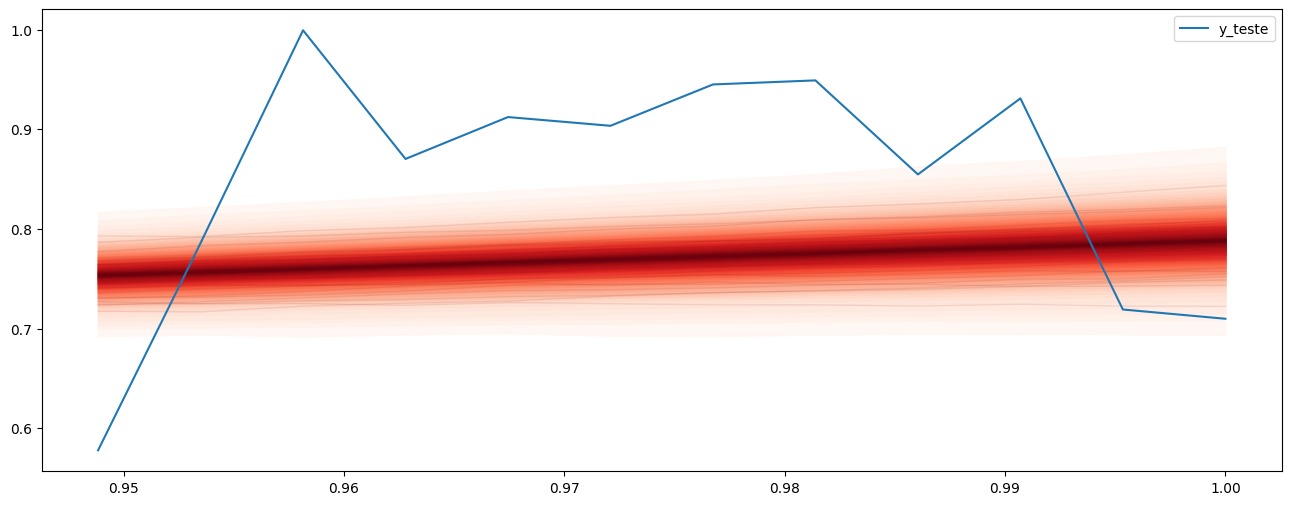

In [88]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [89]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.12918108495676828


###Modelo 4 com Gamma

In [90]:
with pm.Model() as model4:

    # Parâmetros do kernel RatQuad com distribuição Gamma
    l_ratquad = pm.Gamma('l_ratquad', alpha=5, beta=1)
    alpha_ratquad = pm.Gamma('alpha_ratquad', alpha=5, beta=1)
    sigma_ratquad = pm.Gamma('sigma_ratquad', alpha=5, beta=1)

    # Kernel RatQuad
    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)

    # Parâmetros do kernel Matern 3/2 com distribuição Gamma
    l_matern32 = pm.Gamma('l_matern32', alpha=5, beta=1)
    sigma_matern32 = pm.Gamma('sigma_matern32', alpha=5, beta=1)

    # Kernel Matern 3/2
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    # Parâmetros do kernel ExpQuad (aproximação para Gamma)
    l_gamma = pm.Gamma('l_gamma', alpha=5, beta=1)
    sigma_gamma = pm.Gamma('sigma_gamma', alpha=5, beta=1)

    # Kernel ExpQuad
    cov_gamma = sigma_gamma * pm.gp.cov.ExpQuad(1, l_gamma)

    # Soma dos kernels
    cov = cov_ratquad + cov_matern32 + cov_gamma

    # Tendência linear
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.125)
    trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    # Modelo GP
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)

    # Variância do ruído com distribuição Gamma
    sigma = pm.Gamma('sigma', alpha=5, beta=1)

    # Verossimilhança
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1, 1), y=y_treino, noise=sigma)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [91]:
with model4:
  prior4 = pm.sample_prior_predictive()

<ipython-input-92-aaa921fd4eda>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior4, group="prior_predictive", num_samples=100)["y"]
<ipython-input-92-aaa921fd4eda>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior4, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

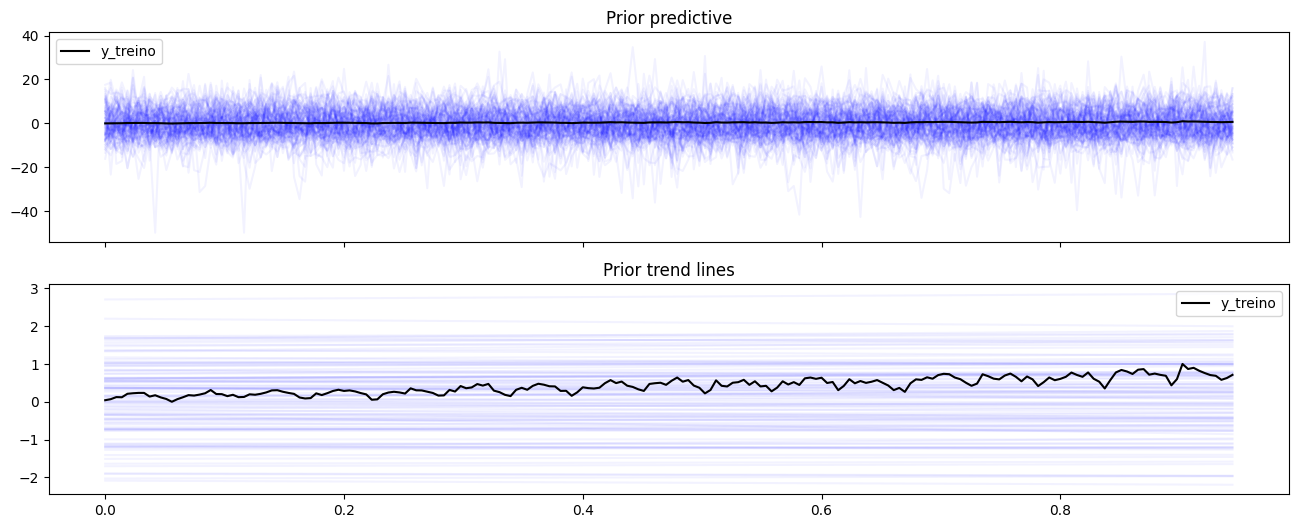

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior4, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
);
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0]);
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior4, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
);
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1]);
ax[1].set_title("Prior trend lines")

In [93]:
with model4:
  trace4 = pm.sample()
pm.summary(trace4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.051,0.969,-1.747,1.842,0.017,0.021,3344.0,1592.0,1.0
b,0.020,0.118,-0.186,0.253,0.002,0.003,3129.0,1414.0,1.0
l_ratquad,4.996,2.238,1.313,9.127,0.043,0.033,2753.0,1609.0,1.0
alpha_ratquad,5.342,2.133,1.989,9.492,0.037,0.028,3277.0,1390.0,1.0
sigma_ratquad,4.735,2.210,1.312,8.903,0.039,0.031,2991.0,1265.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[199],0.069,0.977,-1.734,1.876,0.017,0.021,3368.0,1583.0,1.0
trend[200],0.069,0.977,-1.734,1.875,0.017,0.021,3369.0,1583.0,1.0
trend[201],0.069,0.977,-1.734,1.875,0.017,0.021,3368.0,1583.0,1.0
trend[202],0.069,0.977,-1.734,1.874,0.017,0.021,3367.0,1583.0,1.0


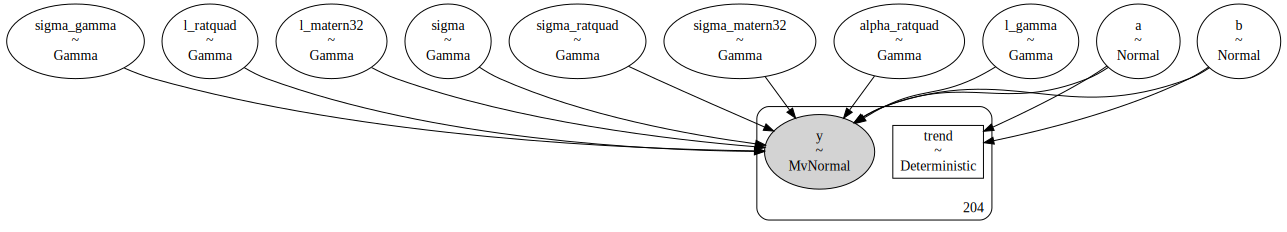

In [94]:
pm.model_to_graphviz(model4)

In [95]:
with model4:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace4, var_names=["x_teste"])

<ipython-input-100-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

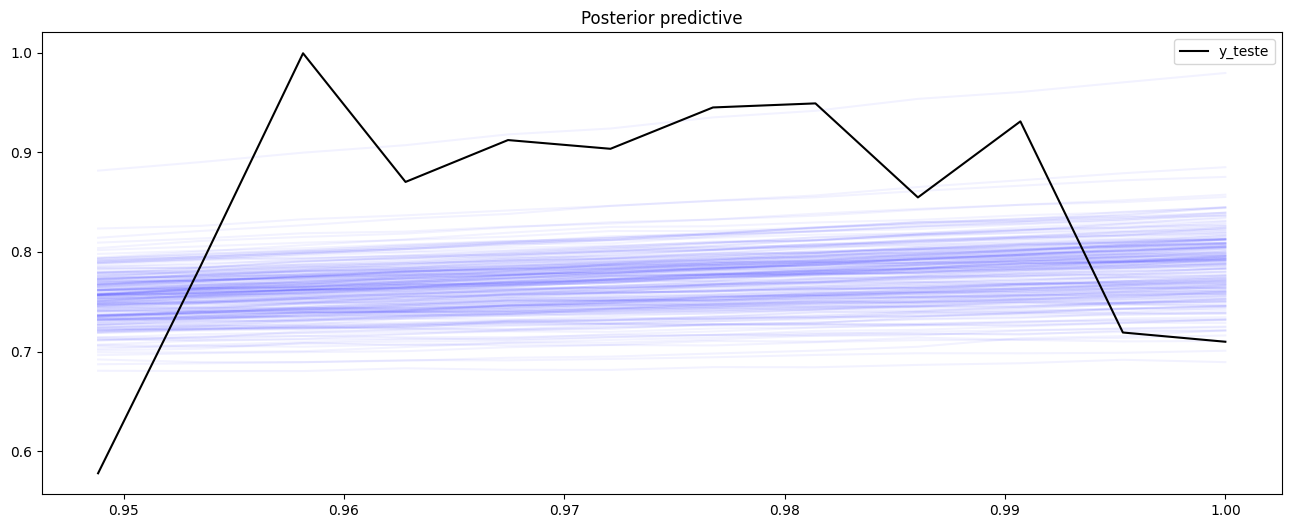

In [100]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [101]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 12, sample: 2000)>
array([[0.76405655, 0.70556273, 0.76857476, ..., 0.76776153, 0.73483401,
        0.74003982],
       [0.76567794, 0.70657033, 0.77475659, ..., 0.77177244, 0.73598291,
        0.74355566],
       [0.77123199, 0.71068572, 0.77626685, ..., 0.77456295, 0.73736313,
        0.7481328 ],
       ...,
       [0.79457373, 0.72663861, 0.79651283, ..., 0.80358485, 0.74966445,
        0.77963382],
       [0.7947404 , 0.73082492, 0.79974488, ..., 0.80600663, 0.75128189,
        0.78424971],
       [0.80044283, 0.73154074, 0.80112426, ..., 0.81060675, 0.75080094,
        0.78741762]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

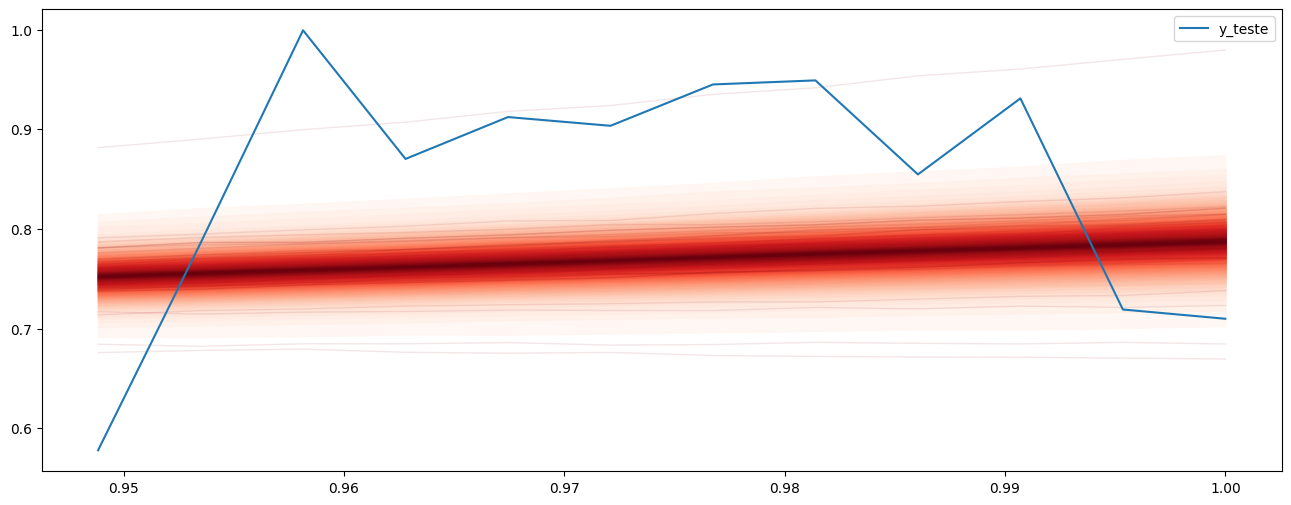

In [102]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [103]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.1293140959055499


###Modelo 5 com Gamma

In [104]:
with pm.Model() as model5:

    # Parâmetros do kernel RatQuad com distribuição Gamma
    l_ratquad = pm.Gamma('l_ratquad', alpha=2, beta=0.5)  # beta = 1/scale = 1/2
    alpha_ratquad = pm.Gamma('alpha_ratquad', alpha=2, beta=0.5)
    sigma_ratquad = pm.Gamma('sigma_ratquad', alpha=2, beta=0.5)

    # Kernel RatQuad
    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)

    # Parâmetros do kernel Matern 3/2 com distribuição Gamma
    l_matern32 = pm.Gamma('l_matern32', alpha=2, beta=0.5)
    sigma_matern32 = pm.Gamma('sigma_matern32', alpha=2, beta=0.5)

    # Kernel Matern 3/2
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    # Parâmetros do kernel ExpQuad (aproximação para Gamma)
    l_gamma = pm.Gamma('l_gamma', alpha=2, beta=0.5)
    sigma_gamma = pm.Gamma('sigma_gamma', alpha=2, beta=0.5)

    # Kernel ExpQuad
    cov_gamma = sigma_gamma * pm.gp.cov.ExpQuad(1, l_gamma)

    # Soma dos kernels
    cov = cov_ratquad + cov_matern32 + cov_gamma

    # Tendência linear
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.125)
    trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    # Modelo GP
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)

    # Variância do ruído com distribuição Gamma
    sigma = pm.Gamma('sigma', alpha=2, beta=0.5)

    # Verossimilhança
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1, 1), y=y_treino, noise=sigma)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [105]:
with model5:
  prior5 = pm.sample_prior_predictive()

<ipython-input-106-63e9052d7413>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior5, group="prior_predictive", num_samples=100)["y"]
<ipython-input-106-63e9052d7413>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior5, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

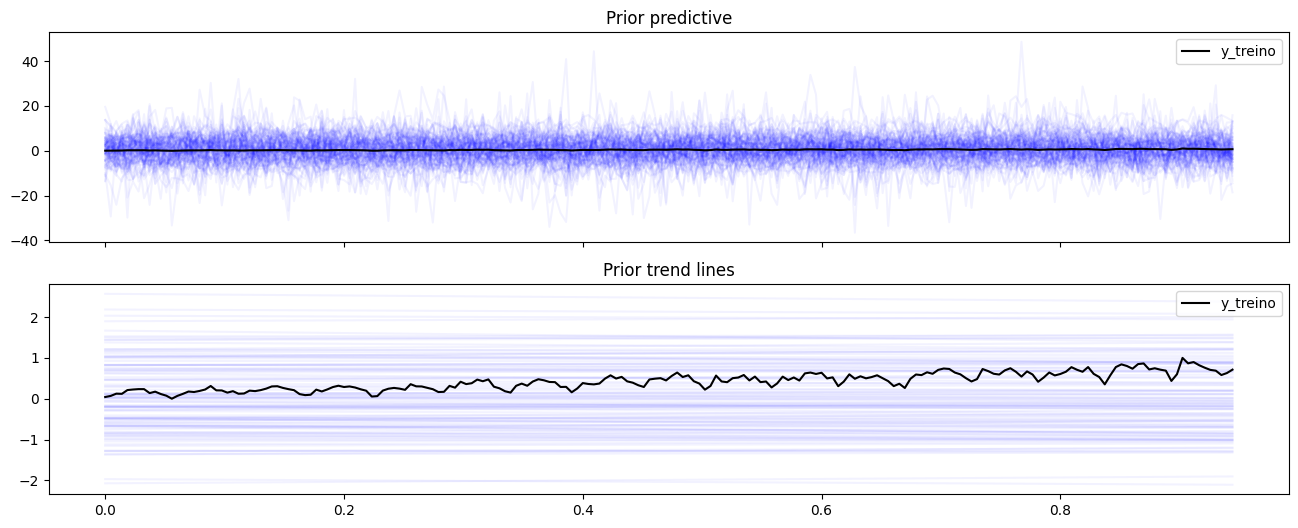

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior5, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
);
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0]);
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior5, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
);
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1]);
ax[1].set_title("Prior trend lines")

In [107]:
with model5:
  trace5 = pm.sample()
pm.summary(trace5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.062,0.935,-1.631,1.852,0.017,0.022,2939.0,1333.0,1.0
b,0.021,0.125,-0.212,0.259,0.002,0.003,3372.0,1511.0,1.0
l_ratquad,3.978,2.704,0.142,9.097,0.051,0.040,2367.0,1355.0,1.0
alpha_ratquad,5.002,2.797,1.039,10.134,0.058,0.045,2382.0,1312.0,1.0
sigma_ratquad,3.407,2.505,0.101,7.815,0.048,0.039,2174.0,1352.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[199],0.082,0.938,-1.592,1.909,0.017,0.022,2993.0,1458.0,1.0
trend[200],0.082,0.938,-1.591,1.910,0.017,0.022,2993.0,1458.0,1.0
trend[201],0.082,0.938,-1.590,1.911,0.017,0.022,2993.0,1458.0,1.0
trend[202],0.082,0.938,-1.590,1.910,0.017,0.022,2994.0,1458.0,1.0


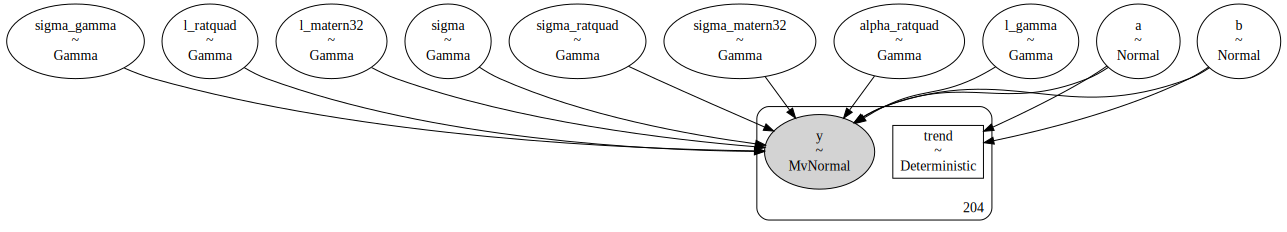

In [108]:
pm.model_to_graphviz(model5)

In [109]:
with model5:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace5, var_names=["x_teste"])

<ipython-input-110-95ff103f091a>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

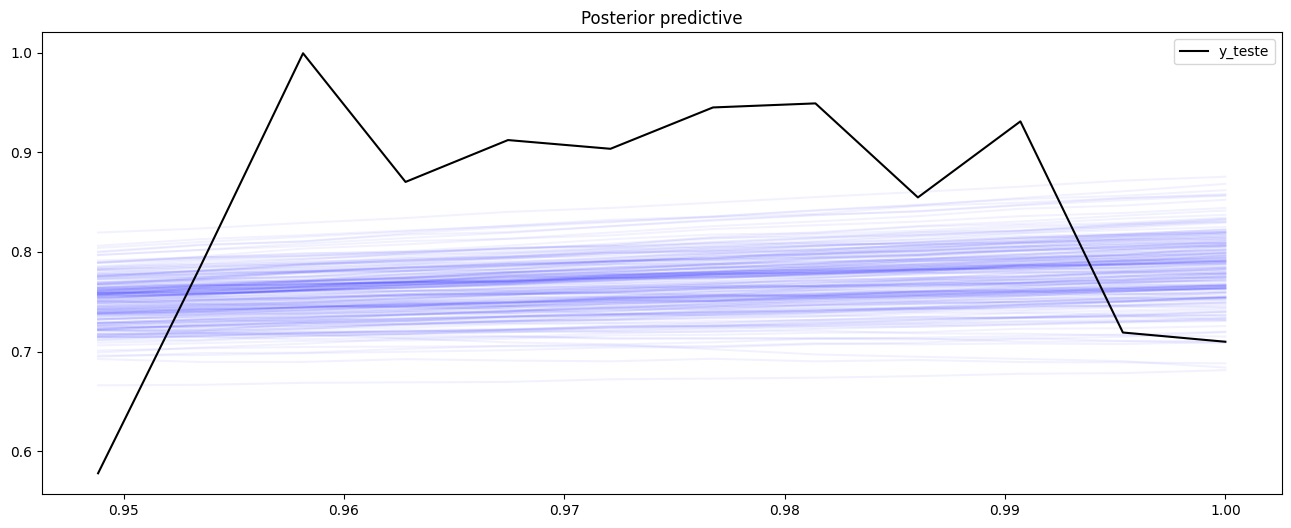

In [110]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [111]:
f_pred_samples = az.extract(pred_m, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples

<xarray.DataArray 'x_teste' (x_teste_dim_2: 12, sample: 2000)>
array([[0.72069586, 0.74202005, 0.75726342, ..., 0.7410973 , 0.77772568,
        0.72213992],
       [0.72134902, 0.74544186, 0.76344533, ..., 0.74590693, 0.78302244,
        0.72456474],
       [0.72707237, 0.74784348, 0.76602892, ..., 0.74936696, 0.78227262,
        0.72632364],
       ...,
       [0.74363559, 0.76979905, 0.78813282, ..., 0.77535723, 0.80396224,
        0.74699409],
       [0.7462553 , 0.77487936, 0.79341249, ..., 0.78040727, 0.80586031,
        0.75097116],
       [0.7492175 , 0.77768287, 0.7973422 , ..., 0.78343807, 0.8093643 ,
        0.75307218]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

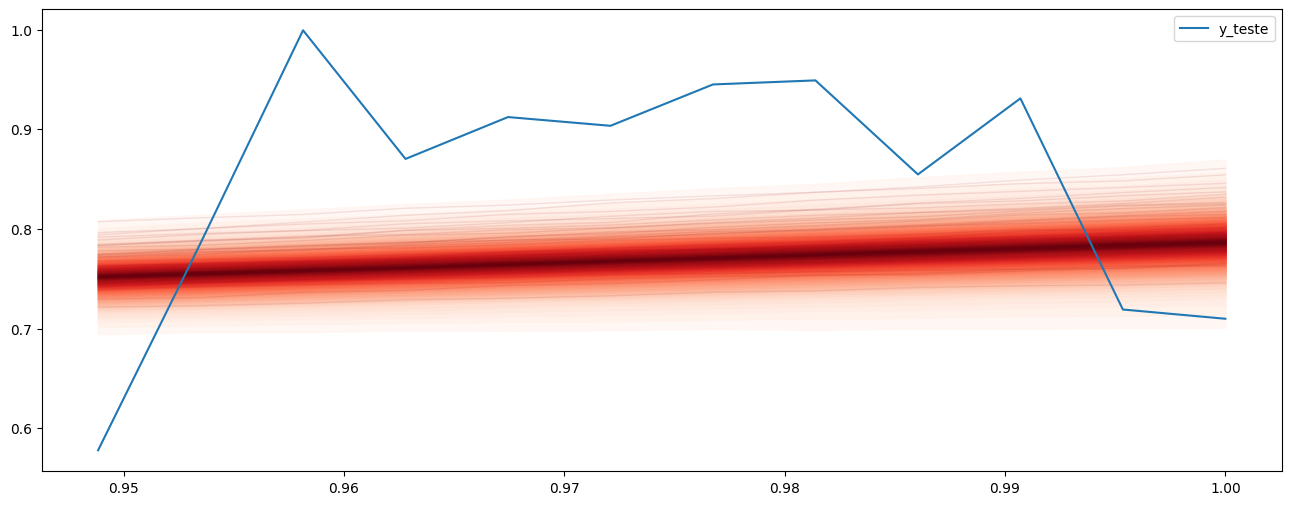

In [112]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [113]:
y_pred = pred_m.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.12949194329117544


# Medição do tempo

In [79]:
final = datetime.now()
print(final - inicio)

2:03:45.275575
